In [22]:
import os
import math
import pickle
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# PyTorch Geometric containers only (no torch_scatter required)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem

In [83]:
cep_path = "/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/41597_2016_BFsdata201686_MOESM94_ESM.csv"

cep = pd.read_csv(cep_path)

# If confnum exists, drop it (WITHOUT inplace so cep isn't None)
if "confnum" in cep.columns:
    cep = cep.drop(columns=["confnum"])

In [79]:
df = pd.read_csv("/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/mmc2_cleaned_2_no_zero_pce.csv")

In [84]:
HARTREE_TO_EV = 27.211386245988
EV_TO_HARTREE = 1.0 / HARTREE_TO_EV
df_h = df.copy()

df_h["homo"] = df_h["homo"] * EV_TO_HARTREE
df_h["gap"]  = df_h["gap"]  * EV_TO_HARTREE

# recompute LUMO to enforce physical consistency
df_h["lumo"] = df_h["homo"] + df_h["gap"]
lumo_shift = cep["lumo"].median() - df_h["lumo"].median()

df_h["homo"] += lumo_shift
df_h["lumo"] += lumo_shift

In [87]:
print("CEP summary:")
print(cep[["homo","lumo","gap"]].describe().loc[["mean","std","min","max"]])

print("\nDF rewritten to CEP scale:")
print(df_h[["homo","lumo","gap"]].describe().loc[["mean","std","min","max"]])
def z_stats(df, cols):
    z = (df[cols] - df[cols].mean()) / df[cols].std()
    return z.describe().loc[["mean","std","min","max"]]

print("\nCEP z-scores:")
print(z_stats(cep, ["homo","lumo","gap"]))

print("\nDF_h z-scores:")
print(z_stats(df_h, ["homo","lumo","gap"]))

CEP summary:
          homo      lumo       gap
mean -0.250342  0.008158  0.258500
std   0.014419  0.019512  0.026236
min  -0.318000 -0.048000  0.199000
max  -0.224000  0.114000  0.431000

DF rewritten to CEP scale:
          homo      lumo       gap
mean -0.097421  0.006527  0.103947
std   0.019705  0.019531  0.021492
min  -0.179854 -0.037985  0.034689
max  -0.060056  0.073297  0.153991

CEP z-scores:
              homo          lumo           gap
mean -5.902452e-17 -4.778175e-17 -5.396527e-16
std   1.000000e+00  1.000000e+00  1.000000e+00
min  -4.692218e+00 -2.878187e+00 -2.267846e+00
max   1.826848e+00  5.424538e+00  6.574848e+00

DF_h z-scores:
              homo          lumo           gap
mean -2.750659e-16  9.403961e-18 -3.667545e-16
std   1.000000e+00  1.000000e+00  1.000000e+00
min  -4.183262e+00 -2.279060e+00 -3.222593e+00
max   1.896169e+00  3.418766e+00  2.328541e+00


In [88]:
df_h

,smiles,homo,lumo,gap,pce
0,CN1C(=O)C(=Cc2occc2C(=O)c2ccc(-c3ncc(C4=CC=CC5...,-0.097178,-0.001570,0.095609,2.112606
1,CN1C(=O)C(=CC2=CC=C(c3cnc(-c4ccc(C(=O)c5ccoc5)...,-0.102720,-0.021709,0.081010,1.980828
2,CN1C(=O)C(=Cc2ncc(-c3ccc(C(=O)c4cocc4C=Cc4ccnc...,-0.102901,-0.015627,0.087274,2.030503
3,CN1C(=O)C(=Cc2nccc(C=Cc3cocc3C(=O)c3ccc(-c4cnc...,-0.105402,0.000725,0.106128,1.130062
4,CN1C(=O)C(=Cc2sc(C#N)c(-c3ncc(-c4ccsc4C(=O)c4c...,-0.119343,-0.013636,0.105707,0.729398
...,...,...,...,...,...
48352,CN1C(=O)C(=Cc2ccsc2C(=O)c2cocc2-c2ccnc(-c3scc4...,-0.075613,-0.001684,0.073929,5.998603
48353,CN1C(=O)C(=Cc2c(F)cc(-c3c(-c4ccncn4)sc4ccc(C#N...,-0.113152,-0.004805,0.108347,0.828925
48354,CN1C(=O)C(=Cc2nccc(-c3sc4ccc(C#N)cc4c3-c3cc(F)...,-0.114873,0.013615,0.128488,0.266871
48355,CN1C(=O)C(=Cc2ccc3nc(-c4sc5ccc(C#N)cc5c4-c4ccc...,-0.106637,-0.001670,0.104967,1.140859


### setup

In [ ]:
@dataclass
class CFG:
    smiles_col: str = "smiles"
    target_cols: Tuple[str, ...] = ("homo", "lumo", "gap", "pce")

    seed: int = 42
    test_frac: float = 0.10
    val_frac: float = 0.10

    # Model size (keep small for M1)
    hidden_dim: int = 64
    msg_dim: int = 128
    num_layers: int = 3
    dropout: float = 0.10

    # Training
    batch_size: int = 128          # <- bump this once precomputed
    lr: float = 2e-4
    weight_decay: float = 1e-4
    max_epochs: int = 80
    patience: int = 5
    grad_clip: float = 2.0

    # Speed knobs
    limit_rows: Optional[int] = None  # set e.g. 5000 for quick test
    num_workers: int = 0              # keep 0 on mac

cfg = CFG()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def make_splits(df, cfg: CFG):
    n = len(df)
    idx = np.arange(n)
    rng = np.random.RandomState(cfg.seed)
    rng.shuffle(idx)

    n_test = int(cfg.test_frac * n)
    n_val  = int(cfg.val_frac * n)

    test_idx = idx[:n_test]
    val_idx  = idx[n_test:n_test + n_val]
    train_idx= idx[n_test + n_val:]

    return (df.iloc[train_idx].reset_index(drop=True),
            df.iloc[val_idx].reset_index(drop=True),
            df.iloc[test_idx].reset_index(drop=True))


### Featurisation

In [90]:
# Small, fixed vocab for atomic numbers to keep feature dims modest.
COMMON_ATOMIC_NUMS = [1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]  # H B C N O F Si P S Cl Br I
ATOMNUM_TO_IDX = {z: i for i, z in enumerate(COMMON_ATOMIC_NUMS)}
ATOM_FDIM = len(COMMON_ATOMIC_NUMS) + 6  # one-hot + 6 numeric/binary

BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
]
BOND_TO_IDX = {bt: i for i, bt in enumerate(BOND_TYPES)}
BOND_FDIM = len(BOND_TYPES) + 2  # one-hot + (conjugated, in_ring)

def atom_features(atom: Chem.rdchem.Atom) -> List[float]:
    z = atom.GetAtomicNum()
    onehot = [0.0] * len(COMMON_ATOMIC_NUMS)
    if z in ATOMNUM_TO_IDX:
        onehot[ATOMNUM_TO_IDX[z]] = 1.0

    degree = float(atom.GetDegree())
    formal_charge = float(atom.GetFormalCharge())
    aromatic = 1.0 if atom.GetIsAromatic() else 0.0
    total_h = float(atom.GetTotalNumHs())

    hybrid = atom.GetHybridization()
    hyb_map = {
        Chem.rdchem.HybridizationType.SP: 1.0,
        Chem.rdchem.HybridizationType.SP2: 2.0,
        Chem.rdchem.HybridizationType.SP3: 3.0,
    }
    hyb_val = hyb_map.get(hybrid, 0.0)
    in_ring = 1.0 if atom.IsInRing() else 0.0

    return onehot + [degree, formal_charge, aromatic, total_h, hyb_val, in_ring]

def bond_features(bond: Chem.rdchem.Bond) -> List[float]:
    bt = bond.GetBondType()
    onehot = [0.0] * len(BOND_TYPES)
    if bt in BOND_TO_IDX:
        onehot[BOND_TO_IDX[bt]] = 1.0
    conjugated = 1.0 if bond.GetIsConjugated() else 0.0
    in_ring = 1.0 if bond.IsInRing() else 0.0
    return onehot + [conjugated, in_ring]

def smiles_to_data(smiles: str, y: np.ndarray) -> Optional[Data]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)

    edge_index = []
    edge_attr = []
    for b in mol.GetBonds():
        i = b.GetBeginAtomIdx()
        j = b.GetEndAtomIdx()
        bf = bond_features(b)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append(bf)
        edge_attr.append(bf)

    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, BOND_FDIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor(y, dtype=torch.float32))

In [91]:
from tqdm.auto import tqdm
import os
import torch

def precompute_graphs(df_split, cfg: CFG, mean, std, out_path: str):
    data_list = []
    bad = 0

    for i in tqdm(range(len(df_h_split)), desc=f"Precomputing -> {out_path}"):
        row = df_h_split.iloc[i]
        smiles = row[cfg.smiles_col]
        targets = row[list(cfg.target_cols)].to_numpy(np.float32)
        y = (targets - mean) / (std + 1e-8)

        data = smiles_to_data(smiles, y)
        if data is None:
            bad += 1
            continue
        data_list.append(data)

    torch.save(data_list, out_path)
    print(f"Saved {len(data_list)} graphs -> {out_path}. Dropped {bad} invalid.")


set_seed(cfg.seed)

# optional quick test
if cfg.limit_rows is not None:
    df_h_work = df_h.sample(cfg.limit_rows, random_state=cfg.seed).reset_index(drop=True)
else:
    df_h_work = df_h.copy()

df_h_work = df_h_work.dropna(subset=[cfg.smiles_col, *cfg.target_cols]).reset_index(drop=True)

train_df, val_df, test_df = make_splits(df_h_work, cfg)

y_train = train_df[list(cfg.target_cols)].to_numpy(np.float32)
mean = y_train.mean(axis=0)
std  = y_train.std(axis=0) + 1e-6

# Only precompute if files don't already exist (so you don't redo work)
if not os.path.exists("train_graphs.pt"):
    precompute_graphs(train_df, cfg, mean, std, "train_graphs.pt")
if not os.path.exists("val_graphs.pt"):
    precompute_graphs(val_df, cfg, mean, std, "val_graphs.pt")
if not os.path.exists("test_graphs.pt"):
    precompute_graphs(test_df, cfg, mean, std, "test_graphs.pt")

# Save mean/std for later de-standardisation
np.save("target_mean.npy", mean)
np.save("target_std.npy", std)

### Dataset and cacheing

In [92]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

class PrecomputedDataset(Dataset):
    def __init__(self, path: str):
        self.data_list = torch.load(path)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

train_loader = DataLoader(PrecomputedDataset("train_graphs.pt"),
                          batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)

val_loader   = DataLoader(PrecomputedDataset("val_graphs.pt"),
                          batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

test_loader  = DataLoader(PrecomputedDataset("test_graphs.pt"),
                          batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

### Models

In [64]:
def index_add_pool(x: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
    B = int(batch.max().item()) + 1 if batch.numel() > 0 else 1
    out = torch.zeros((B, x.size(-1)), device=x.device, dtype=x.dtype)
    out.index_add_(0, batch, x)
    return out

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x): return self.net(x)

class FastMessageLayer(nn.Module):
    """
    Node update only.
    Messages use [x_j || edge_attr] but edge_attr stays fixed.
    """
    def __init__(self, hidden_dim: int, msg_dim: int, dropout: float, use_bn: bool = False):
        super().__init__()
        self.msg = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, msg_dim),
            nn.ReLU(),
            nn.Linear(msg_dim, hidden_dim),
        )
        self.self_lin = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(hidden_dim) if use_bn else None

    def forward(self, x, edge_index, edge_attr):
        if edge_index.numel() == 0:
            x2 = self.self_lin(x)
            if self.use_bn: x2 = self.bn(x2)
            return F.relu(x2), edge_attr

        src, dst = edge_index[0], edge_index[1]

        m_in = torch.cat([x[src], edge_attr], dim=-1)  # [E, 2H]
        m = self.msg(m_in)                             # [E, H]

        agg = torch.zeros_like(x)
        agg.index_add_(0, dst, m)

        x_up = agg + self.self_lin(x)
        if self.use_bn:
            x_up = self.bn(x_up)
        x_up = F.relu(x_up)
        x_up = F.dropout(x_up, p=self.dropout, training=self.training)
        return x_up, edge_attr

class DualMPNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, hidden_dim: int, msg_dim: int, num_layers: int, dropout: float, out_dim: int):
        super().__init__()
        self.node_emb = nn.Linear(node_in, hidden_dim)
        self.edge_emb = nn.Linear(edge_in, hidden_dim)

        self.layers = nn.ModuleList([
            FastMessageLayer(hidden_dim, msg_dim, dropout, use_bn=False)
            for _ in range(num_layers)
        ])

        self.readout_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, data: Data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.node_emb(x))

        if edge_attr.numel() > 0:
            edge_attr = F.relu(self.edge_emb(edge_attr))

        for layer in self.layers:
            x, edge_attr = layer(x, edge_index, edge_attr)

        g_sum = index_add_pool(x, batch)
        counts = torch.bincount(batch, minlength=g_sum.size(0)).clamp_min(1).unsqueeze(-1).to(x.device)
        g_mean = g_sum / counts

        g = torch.cat([g_sum, g_mean], dim=-1)
        return self.readout_mlp(g)


In [93]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        y = batch.y.view(out.shape)
        loss = F.smooth_l1_loss(out, y)
        losses.append(loss.item())
    return float(np.mean(losses))

def train_from_loaders(cfg: CFG, train_loader, val_loader):
    device = torch.device("cpu")
    print("Using device:", device)

    model = DualMPNN(
        node_in=ATOM_FDIM,
        edge_in=BOND_FDIM,
        hidden_dim=cfg.hidden_dim,
        msg_dim=cfg.msg_dim,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        out_dim=len(cfg.target_cols),
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    for epoch in range(1, cfg.max_epochs + 1):
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch:03d}"):
            batch = batch.to(device)
            opt.zero_grad(set_to_none=True)

            out = model(batch)
            y = batch.y.view(out.shape)
            loss = F.smooth_l1_loss(out, y)

            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            opt.step()

            train_losses.append(loss.item())

        tr_loss = float(np.mean(train_losses))
        val_loss = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:03d} | train {tr_loss:.4f} | val {val_loss:.4f}")

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= cfg.patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

model = train_from_loaders(cfg, train_loader, val_loader)

Using device: cpu


Epoch 001:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 001 | train 0.2988 | val 0.2134


Epoch 002:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 002 | train 0.1982 | val 0.1563


Epoch 003:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 003 | train 0.1632 | val 0.1547


Epoch 004:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 004 | train 0.1495 | val 0.1228


Epoch 005:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 005 | train 0.1343 | val 0.1123


Epoch 006:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 006 | train 0.1268 | val 0.1068


Epoch 007:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 007 | train 0.1188 | val 0.1054


Epoch 008:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 008 | train 0.1150 | val 0.1196


Epoch 009:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 009 | train 0.1108 | val 0.1033


Epoch 010:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 010 | train 0.1061 | val 0.0890


Epoch 011:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 011 | train 0.1033 | val 0.1067


Epoch 012:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 012 | train 0.1014 | val 0.0844


Epoch 013:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 013 | train 0.0976 | val 0.0814


Epoch 014:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 014 | train 0.0953 | val 0.0866


Epoch 015:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 015 | train 0.0936 | val 0.0823


Epoch 016:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 016 | train 0.0919 | val 0.0788


Epoch 017:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 017 | train 0.0897 | val 0.0794


Epoch 018:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 018 | train 0.0888 | val 0.0781


Epoch 019:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 019 | train 0.0875 | val 0.0712


Epoch 020:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 020 | train 0.0843 | val 0.0736


Epoch 021:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 021 | train 0.0833 | val 0.0743


Epoch 022:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 022 | train 0.0829 | val 0.0738


Epoch 023:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 023 | train 0.0817 | val 0.0689


Epoch 024:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 024 | train 0.0791 | val 0.0698


Epoch 025:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 025 | train 0.0788 | val 0.0689


Epoch 026:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 026 | train 0.0770 | val 0.0637


Epoch 027:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 027 | train 0.0766 | val 0.0668


Epoch 028:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 028 | train 0.0751 | val 0.0591


Epoch 029:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 029 | train 0.0733 | val 0.0676


Epoch 030:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 030 | train 0.0729 | val 0.0639


Epoch 031:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 031 | train 0.0703 | val 0.0603


Epoch 032:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 032 | train 0.0701 | val 0.0600


Epoch 033:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 033 | train 0.0691 | val 0.0590
Early stopping.


In [94]:
mean = np.load("target_mean.npy")
std  = np.load("target_std.npy")

@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    preds = []
    ys = []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        preds.append(out.detach().cpu())
        ys.append(batch.y.view(out.shape).detach().cpu())
    return torch.cat(preds, dim=0).numpy(), torch.cat(ys, dim=0).numpy()

device = torch.device("cpu")
pred_std, y_std = predict_all(model, test_loader, device)

pred = pred_std * std + mean
y_true = y_std * std + mean

mae = np.mean(np.abs(pred - y_true), axis=0)
for name, m in zip(cfg.target_cols, mae):
    print(f"MAE {name:>4s}: {m:.4f}")

MAE homo: 0.0042
MAE lumo: 0.0050
MAE  gap: 0.0061
MAE  pce: 0.5199


In [95]:
from sklearn.metrics import r2_score

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    preds = []
    trues = []

    for batch in loader:
        batch = batch.to(device)
        out = model(batch)

        preds.append(out.detach().cpu())
        trues.append(batch.y.view(out.shape).detach().cpu())

    preds = torch.cat(preds, dim=0).numpy()
    trues = torch.cat(trues, dim=0).numpy()
    return preds, trues


device = torch.device("cpu")

pred_std, y_std = get_predictions(model, test_loader, device)

# De-standardise
pred = pred_std * std + mean
y_true = y_std * std + mean

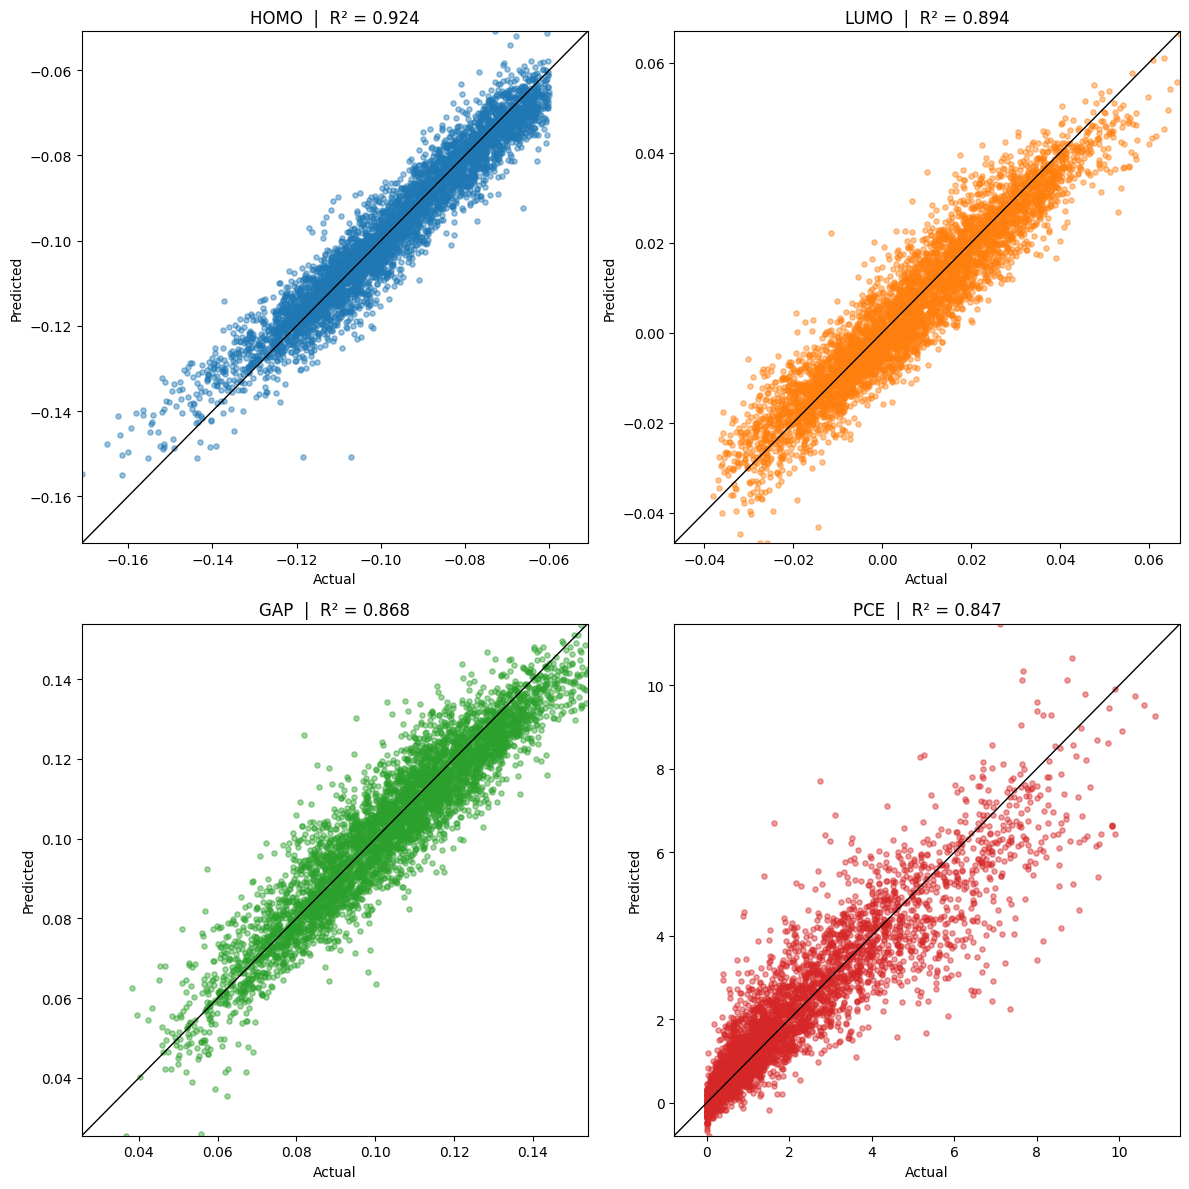

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

target_names = cfg.target_cols
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

r2_scores = {}
rmse_scores = {}

for i, ax in enumerate(axes):
    y_t = y_true[:, i]
    y_p = pred[:, i]

    r2 = r2_score(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))

    r2_scores[target_names[i]] = r2
    rmse_scores[target_names[i]] = rmse

    ax.scatter(y_t, y_p, alpha=0.45, s=14, color=colors[i])
    lims = [
        min(y_t.min(), y_p.min()),
        max(y_t.max(), y_p.max())
    ]
    ax.plot(lims, lims, color="black", linewidth=1)

    ax.set_title(f"{target_names[i].upper()}  |  R² = {r2:.3f}")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()
plt.show()

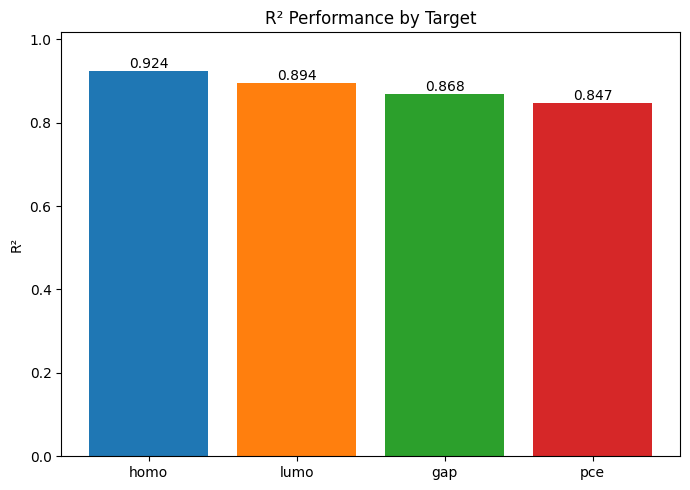

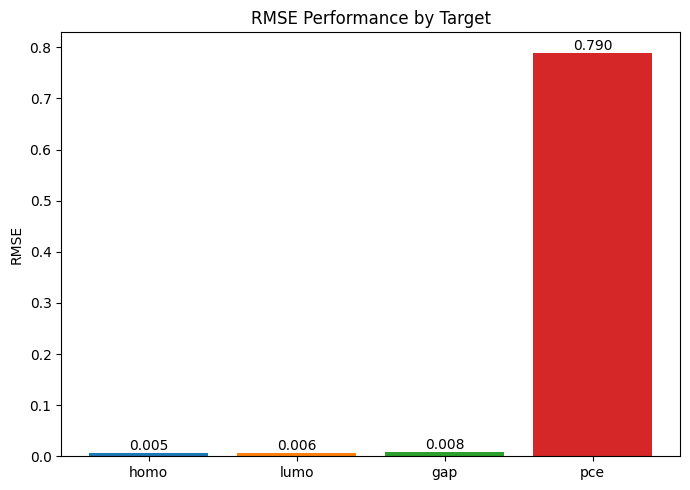

In [97]:
plt.figure(figsize=(7, 5))

names = list(r2_scores.keys())
values = [r2_scores[n] for n in names]

plt.bar(names, values, color=colors)
plt.ylabel("R²")
plt.title("R² Performance by Target")
plt.ylim(0, max(values) * 1.1)

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))

values = [rmse_scores[n] for n in names]

plt.bar(names, values, color=colors)
plt.ylabel("RMSE")
plt.title("RMSE Performance by Target")

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [98]:
SAVE_PATH = "pretrained_gnn.pt"

# mean/std are numpy arrays of shape (4,) used for standardising targets during big training
ckpt = {
    "state_dict": model.state_dict(),
    "mean": mean.astype(np.float32),
    "std": std.astype(np.float32),
    "target_cols": cfg.target_cols,
    "model_cfg": {
        "hidden_dim": cfg.hidden_dim,
        "msg_dim": cfg.msg_dim,
        "num_layers": cfg.num_layers,
        "dropout": cfg.dropout,
    }
}
torch.save(ckpt, SAVE_PATH)
print("Saved:", SAVE_PATH)

Saved: pretrained_gnn.pt
